In [1]:
!conda install --yes -c pytorch pytorch=1.7.1 torchvision cudatoolkit=11.0
!pip install ftfy regex tqdm
!pip install git+https://github.com/openai/CLIP.git

Retrieving notices: ...working... done

# >>>>>>>>>>>>>>>>>>>>>> ERROR REPORT <<<<<<<<<<<<<<<<<<<<<<

    Traceback (most recent call last):
      File "/opt/conda/lib/python3.10/site-packages/conda/gateways/repodata/__init__.py", line 161, in conda_http_errors
        yield
      File "/opt/conda/lib/python3.10/site-packages/conda/gateways/repodata/__init__.py", line 127, in repodata
        response.raise_for_status()
      File "/opt/conda/lib/python3.10/site-packages/requests/models.py", line 1021, in raise_for_status
        raise HTTPError(http_error_msg, response=self)
    requests.exceptions.HTTPError: 404 Client Error: Not Found for url: https://conda.anaconda.org/rapidsai/linux-64/current_repodata.json
    
    During handling of the above exception, another exception occurred:
    
    Traceback (most recent call last):
      File "/opt/conda/lib/python3.10/site-packages/requests/models.py", line 971, in json
        return complexjson.loads(self.text, **kwargs)
      File "

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import numpy as np
import cv2
import matplotlib.pyplot as plt
from sklearn import metrics
from torch.autograd import Variable
import os
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
import random

import os
import clip
import torch
from torchvision.datasets import CIFAR100
from PIL import Image, ImageEnhance
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import numpy as np
import cv2
import matplotlib.pyplot as plt
from sklearn import metrics
from torch.autograd import Variable
import os
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
import tensorflow as tf
from tensorflow.keras import layers

import numpy as np
import pandas as pd 
import json
import os
from random import randint
from collections import Counter


/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-L/14@336px", device)

100%|████████████████████████████████████████| 891M/891M [00:06<00:00, 150MiB/s]


# data loader

In [4]:
with open('/kaggle/input/vizwiz/vizwiz_data_ver1/data/Annotations/train.json') as file:
    json_data = file.read()

    data = json.loads(json_data)

In [5]:
data=data[:5000]

In [6]:
labels1=[]
labels2=[]

for item in data:
    labels1.append(item['answer_type'])
    answers = item['answers']
    yes=[]
    maybe=[]
    for answer in answers:
        if answer['answer_confidence']=="yes":
            yes.append(answer)
        else:
            maybe.append(answer)
    use=[]
    if len(yes)>0:
        use=yes
    else:
        use=maybe
    common=[]
    i=0
    for t in use:
        common.append(use[i]['answer'])
        i=i+1
    
    counter = Counter(common)
    most_common = counter.most_common()
    max_count = most_common[0][1]
    most_repeated_items = [item for item, count in most_common if count == max_count]
    labels2.append(most_repeated_items[0])

    
counter = Counter(labels1)
labels1 = sorted(list(dict.fromkeys(labels1)))
labels1 = sorted(labels1, key=lambda x: (-counter[x], x))
counter = Counter(labels2)
labels2 = sorted(list(dict.fromkeys(labels2)))
labels2 = sorted(labels2, key=lambda x: (-counter[x], x))

In [7]:
labelstr=[]
for item in data:
    labelstr.append(item['answer_type'])
    

<Axes: >

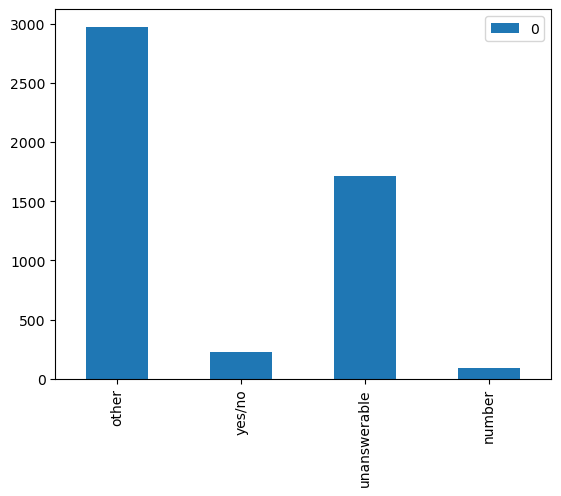

In [8]:
letter_counts = Counter(labelstr)
df = pd.DataFrame.from_dict(letter_counts, orient='index')
df.plot(kind='bar')

In [9]:
class myDataset(Dataset):
  def __init__(self, array,labels1,labels2,tr=False):
    self.data = array
    self.labels1=labels1
    self.labels2=labels2
    self.tr=tr
#     self.label = label
      # stuff
      
  def __getitem__(self, index):
        item=self.data[index]
        answerable = item['answerable']
        image = item['image']
        question = item['question']
        answer_type = item['answer_type']
        answers = item['answers']
        answer1  = answers[0]['answer']
        answer2  = answers[1]['answer']
        answer3  = answers[2]['answer']
        answer4  = answers[3]['answer']
        answer5  = answers[4]['answer']
        answer6  = answers[5]['answer']
        answer7  = answers[6]['answer']
        answer8  = answers[7]['answer']
        answer9  = answers[8]['answer']
        answer10 = answers[9]['answer']
        
        yes=[]
        maybe=[]
        for answer in answers:
            if answer['answer_confidence']=="yes":
                yes.append(answer)
            else:
                maybe.append(answer)
        use=[]
        if len(yes)>0:
            use=yes
        else:
            use=maybe
        common=[]
        i=0
        for t in use:
            common.append(use[i]['answer'])
            i=i+1

        with torch.no_grad():
            image_data = Image.open('/kaggle/input/vizwiz/vizwiz_data_ver1/data/Images/'+image)
            if(self.tr):
                zz=random.randint(0,6)
                if(zz==0):
                    image_data = image_data.transpose(Image.FLIP_LEFT_RIGHT)
                elif(zz==1):
                    image_data = image_data.transpose(Image.FLIP_TOP_BOTTOM)
                elif(zz==2):
                    image_data = image_data.transpose(Image.ROTATE_90)
                elif(zz==3):
                    enhancer = ImageEnhance.Brightness(image_data)
                    image_data = enhancer.enhance(1.5)
                elif(zz==4):
                    enhancer = ImageEnhance.Brightness(image_data)
                    image_data = enhancer.enhance(0.5)
#                 elif(zz==5):
#                     Rotated_image = imutils.rotate(image, angle=randint(0,180))
            image_input = preprocess(image_data).unsqueeze(0).to(device)
            text_input = clip.tokenize([question]).to(device)            

        with torch.no_grad():
            image_features = model.encode_image(image_input)
            text_in_features = model.encode_text(text_input)
            channel1=torch.tensor (image_features).float().clone().detach()
            channel2=torch.tensor (text_in_features).float().clone().detach()
        datrain = torch.cat((channel1.unsqueeze(1), channel2.unsqueeze(1)), dim=1).clone().detach().to(device)
        
        counter = Counter(common)
        most_common = counter.most_common()

        max_count = most_common[0][1]
        most_repeated_items = [item for item, count in most_common if count == max_count]
        minimum=np.inf
        for x in most_repeated_items:
            if x in labels2:
                index = labels2.index(x)
                if index<minimum:
                    minimum=index
        anstype=labels1.index(answer_type)
        
        l1 = [0] * 4
        l1[int(anstype)] = 1
        
        l2 = [0] * len(labels2)
        l2[int(minimum)] = 1
        
        
        datalabel1=torch.tensor([l1]).clone().detach().to(device)
        datalabel2=torch.tensor([l2]).clone().detach().to(device)

        return datrain, datalabel1, datalabel2

  def __len__(self):
      return len(self.data) # of how many examples(images?) you have

#Model

In [10]:
class Model(nn.Module):
    def __init__(self,outl):
        super(Model, self).__init__()
       # Linear layers
        self.linear1 = nn.Linear(768 * 2, 256)
        self.linear2 = nn.Linear(4, outl)
        self.linear3 = nn.Linear(256,512)
        self.linear4 = nn.Linear(512,256)


        
        self.dropout = nn.Dropout (p=0.5)
        self.activation = nn.ReLU()
        self.activation2 = nn.Sigmoid()
        self.softmax =nn.Softmax ()
        # Normalization layer
        self.norm = nn.LayerNorm(256)

        # Attention layer
        self.attention = nn.MultiheadAttention(embed_dim=256, num_heads=4)

        # Output layer
        self.output_layer1 = nn.Linear(256,4) 
        self.output_layer2 = nn.Linear(256,outl)



    def forward(self, x):
        x = torch.tensor(x).clone().detach().to(device)
        # Reshape input to (batch_size, sequence_length, embedding_size)
        x = x.view(x.size(0), -1, 768 * 2)
        # Apply linear layers
        x = self.linear1(x)


        # Apply normalization layer
        x = self.norm(x)
        x = self.dropout(x)
        x = self.activation(x)
        
#         # Transpose to (sequence_length, batch_size, embedding_size)
#         x = x.transpose(0, 1)
#         # Apply attention layer
#         x, _ = self.attention(x, x, x)
#         # Transpose back to (batch_size, sequence_length, embedding_size)
#         x = x.transpose(0, 1)

        # Apply output layer
        label1 = self.output_layer1(x)
        y = self.linear2(label1)
        y = self.activation2(y)
        label2 = self.output_layer2(x)
        label2=label2*y
        return label1,label2

training loop

In [11]:
X_train_temp, X_test, y_train_temp, y_test = train_test_split(data, labelstr, test_size=0.05, stratify=labelstr, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_temp, y_train_temp, test_size=0.3, stratify=y_train_temp, random_state=42)
customDataset=myDataset(data,labels1,labels2)
customDataset_train=myDataset(X_train,labels1,labels2,True)
customDataset_val=myDataset(X_val,labels1,labels2,False)
customDataset_test=myDataset(X_test,labels1,labels2,False)
whole_dataloader = DataLoader(customDataset, batch_size=256,shuffle=True, num_workers=0)
train_dataloader = DataLoader(customDataset_train, batch_size=256,shuffle=True, num_workers=0)
val_dataloader = DataLoader(customDataset_val, batch_size=256,shuffle=True, num_workers=0)
test_dataloader = DataLoader(customDataset_test, batch_size=256,shuffle=True, num_workers=0)

In [12]:
def run_model(model,dataloader, optimizer,train = True ):
    if train:
        model.train()
    else:
        model.eval() 
    totalacc=0
    pred = []
    labels = []
    loss = nn.CrossEntropyLoss()
    total_loss = 0
    for (data, label1, label2) in dataloader:
        optimizer.zero_grad()
        output1,output2 = model(data)
        loss_ = loss(torch.squeeze(output1.float()), torch.squeeze(torch.tensor(label1).to(device).float()))
        loss_ += loss(torch.squeeze(output2.float()), torch.squeeze(torch.tensor(label2).to(device).float()))

        total_loss += loss_.item()
        if (train):
            loss_.backward()
            scheduler.step(loss_)

        optimizer.step()
        pred += [output1,output2]
        labels += [label1,label2]
        acc=0
        i=0
        
        for l in label2:
            if torch.argmax(F.log_softmax(label2[i][0].float(), dim=0)).item()==torch.argmax(F.log_softmax(output2[i][0].float(), dim=0)).item():
                acc+=1
                totalacc+=1
            i+=1
        print("accuracy: ",acc/256)
        print("----------------------------------------------------------------")
        print("losssss",loss_)
        print("----------------------------------------------------------------")
    return labels,pred, total_loss/len(dataloader),totalacc

In [13]:
print stop checkpoint

SyntaxError: Missing parentheses in call to 'print'. Did you mean print(...)? (2324505595.py, line 1)

In [ ]:
mymodel=Model(len(labels2)).to(device)
epoch = 4
train_accuracy=[]
val_accuracy=[]
train_loss=[]
val_loss=[]
optimizer = torch.optim.Adam(mymodel.parameters(), lr=0.01, weight_decay=.1)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=5, factor=.7, threshold=1e-4)

for e in range(epoch):
    labels,pred,loss,totalacc=run_model(mymodel,train_dataloader,optimizer)
    print("train passed ------------------------------------------------------------------------------------------------")
    labels,pred,loss2,totalacc2=run_model(mymodel,val_dataloader,optimizer,False)
  
  # calculate acc, f1 score, recall ......
    print("epoch passed ------------------------------------------------------------------------------------------------")
    print("total loss",loss)
    train_loss.append(loss)
    print("train accuracy",totalacc/len(y_train))
    train_accuracy.append(totalacc/len(y_train))
    print("total val loss",loss2)
    val_loss.append(loss2)
    print("accuracy val",totalacc2/len(y_val))
    val_accuracy.append(totalacc2/len(y_val))
    

In [ ]:
import matplotlib.pyplot as plt

def plot_broken_line(data,y,t):
    x = range(len(data))  # Generate x-axis values as indices of the list
    plt.plot(x, data, 'r--')  # Plot the data as a broken line with red dashed line style
    plt.xlabel('epochs')
    plt.ylabel(y)
    plt.title(t)
    plt.show()

plot_broken_line(train_loss,"cross entropy loss","training loss")
plot_broken_line(val_loss,"cross entropy loss","validation loss")
plot_broken_line(train_accuracy,"accuracy","training accuracy")
plot_broken_line(val_accuracy,"accuracy","validation accuracy")

In [ ]:
labels,pred,loss3,totalacc3=run_model(mymodel,test_dataloader,optimizer,False)
print("epoch passed ------------------------------------------------------------------------------------------------")
print("total loss",loss3)
print("accuracy",totalacc3/len(y_test))

In [ ]:
print(train_accuracy)
print(val_accuracy)

In [15]:
class myDataset2(Dataset):
  def __init__(self, array,labels1,labels2,tr=False):
    self.data = array
    self.labels1=labels1
    self.labels2=labels2
    self.tr=tr
#     self.label = label
      # stuff
      
  def __getitem__(self, index):
        item=self.data[index]
        answerable = item['answerable']
        image = item['image']
        question = item['question']
        answer_type = item['answer_type']
        answers = item['answers']
        answer1  = answers[0]['answer']
        answer2  = answers[1]['answer']
        answer3  = answers[2]['answer']
        answer4  = answers[3]['answer']
        answer5  = answers[4]['answer']
        answer6  = answers[5]['answer']
        answer7  = answers[6]['answer']
        answer8  = answers[7]['answer']
        answer9  = answers[8]['answer']
        answer10 = answers[9]['answer']
        
        yes=[]
        maybe=[]
        for answer in answers:
            if answer['answer_confidence']=="yes":
                yes.append(answer)
            else:
                maybe.append(answer)
        use=[]
        if len(yes)>0:
            use=yes
        else:
            use=maybe
        common=[]
        i=0
        for t in use:
            common.append(use[i]['answer'])
            i=i+1

        with torch.no_grad():
            image_data = Image.open('/kaggle/input/vizwiz/vizwiz_data_ver1/data/Images/'+image)
            if(self.tr):
                zz=random.randint(0,6)
                if(zz==0):
                    image_data = image_data.transpose(Image.FLIP_LEFT_RIGHT)
                elif(zz==1):
                    image_data = image_data.transpose(Image.FLIP_TOP_BOTTOM)
                elif(zz==2):
                    image_data = image_data.transpose(Image.ROTATE_90)
                elif(zz==3):
                    enhancer = ImageEnhance.Brightness(image_data)
                    image_data = enhancer.enhance(1.5)
                elif(zz==4):
                    enhancer = ImageEnhance.Brightness(image_data)
                    image_data = enhancer.enhance(0.5)
#                 elif(zz==5):
#                     Rotated_image = imutils.rotate(image, angle=randint(0,180))
            image_input = preprocess(image_data).unsqueeze(0).to(device)
            text_input = clip.tokenize([question]).to(device)            

        with torch.no_grad():
            image_features = model.encode_image(image_input)
            text_in_features = model.encode_text(text_input)
            channel1=torch.tensor (image_features).float().clone().detach()
            channel2=torch.tensor (text_in_features).float().clone().detach()
        datrain = torch.cat((channel1.unsqueeze(1), channel2.unsqueeze(1)), dim=1).clone().detach().to(device)
        
#         counter = Counter(common)
#         most_common = counter.most_common()

#         max_count = most_common[0][1]
#         most_repeated_items = [item for item, count in most_common if count == max_count]
#         minimum=np.inf
#         for x in most_repeated_items:
#             if x in labels2:
#                 index = labels2.index(x)
#                 if index<minimum:
#                     minimum=index
#         anstype=labels1.index(answer_type)
        
#         l1 = [0] * 4
#         l1[int(anstype)] = 1
        
#         l2 = [0] * len(labels2)
#         l2[int(minimum)] = 1
        
        
        datalabel1=torch.tensor([answerable]).clone().detach().to(device)

        return datrain, datalabel1

  def __len__(self):
      return len(self.data) # of how many examples(images?) you have

In [16]:
class Model2(nn.Module):
    def __init__(self):
        super(Model2, self).__init__()
       # Linear layers
        self.linear1 = nn.Linear(768 * 2, 256)
#         self.linear2 = nn.Linear(4, outl)
        self.linear3 = nn.Linear(256,512)
        self.linear4 = nn.Linear(512,256)


        
        self.dropout = nn.Dropout (p=0.5)
        self.activation = nn.ReLU()
        self.activation2 = nn.Sigmoid()
        self.softmax =nn.Softmax ()
        # Normalization layer
        self.norm = nn.LayerNorm(256)

        # Attention layer
        self.attention = nn.MultiheadAttention(embed_dim=256, num_heads=4)

        # Output layer
        self.output_layer1 = nn.Linear(256,1) 
#         self.output_layer2 = nn.Linear(256,outl)



    def forward(self, x):
        x = torch.tensor(x).clone().detach().to(device)
        # Reshape input to (batch_size, sequence_length, embedding_size)
        x = x.view(x.size(0), -1, 768 * 2)
        # Apply linear layers
        x = self.linear1(x)


        # Apply normalization layer
        x = self.norm(x)
        x = self.dropout(x)
        x = self.activation(x)
        
        
        # Transpose to (sequence_length, batch_size, embedding_size)
        x = x.transpose(0, 1)
        # Apply attention layer
        x, _ = self.attention(x, x, x)
        # Transpose back to (batch_size, sequence_length, embedding_size)
        x = x.transpose(0, 1)
        

        # Apply output layer
        label1 = self.output_layer1(x)
#         y = self.linear2(label1)
#         y = self.activation2(y)
#         label2 = self.output_layer2(x)
#         label2=label2*y
        return label1

In [17]:
customDataset2=myDataset(data,labels1,labels2)
customDataset_train2=myDataset2(X_train,labels1,labels2,True)
customDataset_val2=myDataset2(X_val,labels1,labels2,False)
customDataset_test2=myDataset2(X_test,labels1,labels2,False)
whole_dataloader2 = DataLoader(customDataset2, batch_size=256,shuffle=True, num_workers=0)
train_dataloader2 = DataLoader(customDataset_train2, batch_size=256,shuffle=True, num_workers=0)
val_dataloader2 = DataLoader(customDataset_val2, batch_size=256,shuffle=True, num_workers=0)
test_dataloader2 = DataLoader(customDataset_test2, batch_size=256,shuffle=True, num_workers=0)

In [21]:
def run_model2(model,dataloader, optimizer,train = True ):
    if train:
        model.train()
    else:
        model.eval() 
    totalacc=0
    pred = []
    labels = []
    loss = nn.L1Loss()
    total_loss = 0
    for (data, label1) in dataloader:
        optimizer2.zero_grad()
        output1 = model(data)
#         print(output1.shape)
#         print(output1)
#         print(torch.tensor(output1).float())
        loss_ = loss(torch.squeeze(output1.float()), torch.squeeze(torch.tensor(label1).to(device).float()))

        total_loss += loss_.item()
        if (train):
            loss_.backward()
            scheduler2.step(loss_)

        optimizer2.step()
        pred += [output1]
        labels += [label1]
        acc=0
        i=0
#         print(output1[i][0].float().item())
#         print(label1[i][0].float().item())
#         print(label1[i][0].float().item()>0.5)
#         print( output1[i][0].float().item()==1)
#         print((label1[i][0].float().item()==1 and output1[i][0].float().item()0.5))
#         print((label1[i][0].float().item()==1 and output1[i][0].float().item()>0.5))
#         print((label1[i][0].float().item()>0.5 and output1[i][0].float().item()==1.0) or (label1[i][0].float().item()<0.5 and output1[i][0].float().item()==0.0))
        for l in label1:
#             if abs(label1[i][0].float().item()-output1[i][0].float().item())<0.5:
#                 acc+=1
#                 totalacc+=1           
            if (label1[i][0].float().item()==1 and output1[i][0].float().item()>0.5) or (label1[i][0].float().item()==0 and output1[i][0].float().item()<0.5):
                acc+=1
                totalacc+=1
            i+=1
        print("accuracy: ",acc/256)
        print("----------------------------------------------------------------")
        print("losssss",loss_)
        print("----------------------------------------------------------------")
    return labels,pred, total_loss/len(dataloader),totalacc

In [25]:
mymodel2=Model2().to(device)
epoch = 4
train_accuracy2=[]
val_accuracy2=[]
train_loss2=[]
val_loss2=[]
optimizer2 = torch.optim.Adam(mymodel2.parameters(), lr=0.00001, weight_decay=.1)
scheduler2 = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer2, patience=5, factor=.7, threshold=1e-4)

for e in range(epoch):
    labels2,pred2,loss21,totalacc21=run_model2(mymodel2,train_dataloader2,optimizer2)
    print("train passed ------------------------------------------------------------------------------------------------")
    labels2,pred2,loss22,totalacc22=run_model2(mymodel2,val_dataloader2,optimizer2,False)
  
  # calculate acc, f1 score, recall ......
    print("epoch passed ------------------------------------------------------------------------------------------------")
    print("total loss",loss21)
    train_loss2.append(loss21)
    print("train accuracy",totalacc21/len(y_train))
    train_accuracy2.append(totalacc21/len(y_train))
    print("total val loss",loss22)
    val_loss2.append(loss22)
    print("accuracy val",totalacc22/len(y_val))
    val_accuracy2.append(totalacc22/len(y_val))
    

/tmp/ipykernel_28/3218481495.py:70: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  channel1=torch.tensor (image_features).float().clone().detach()
/tmp/ipykernel_28/3218481495.py:71: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  channel2=torch.tensor (text_in_features).float().clone().detach()
/tmp/ipykernel_28/99253527.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x).clone().detach().to(device)
/tmp/ipykernel_28/1490953845.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.cl

accuracy:  0.26171875
----------------------------------------------------------------
losssss tensor(0.7172, device='cuda:0', grad_fn=<MeanBackward0>)
----------------------------------------------------------------
accuracy:  0.30859375
----------------------------------------------------------------
losssss tensor(0.6865, device='cuda:0', grad_fn=<MeanBackward0>)
----------------------------------------------------------------
accuracy:  0.30859375
----------------------------------------------------------------
losssss tensor(0.6528, device='cuda:0', grad_fn=<MeanBackward0>)
----------------------------------------------------------------
accuracy:  0.30859375
----------------------------------------------------------------
losssss tensor(0.6650, device='cuda:0', grad_fn=<MeanBackward0>)
----------------------------------------------------------------
accuracy:  0.34375
----------------------------------------------------------------
losssss tensor(0.6155, device='cuda:0', grad_fn=

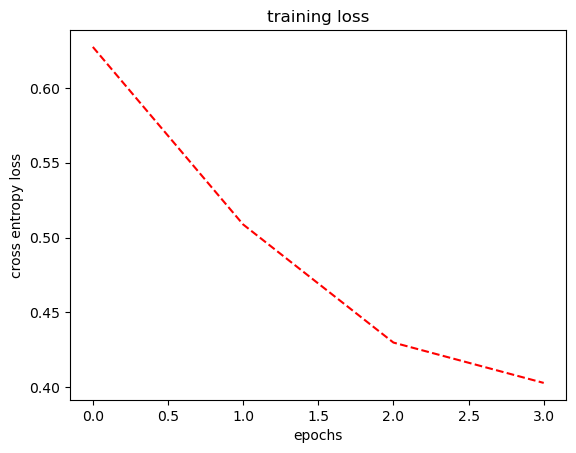

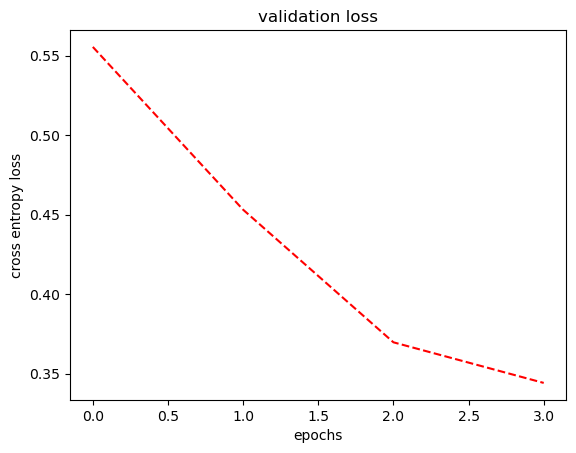

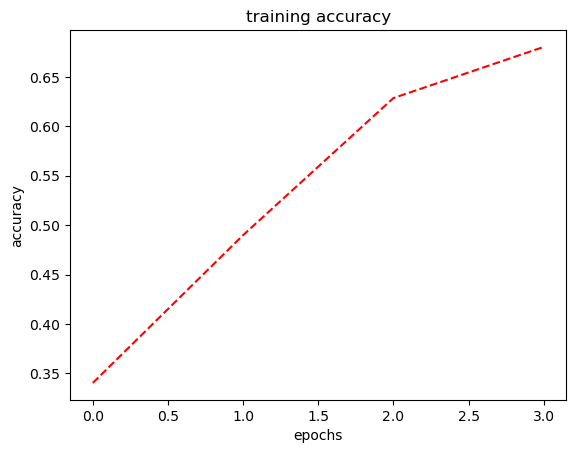

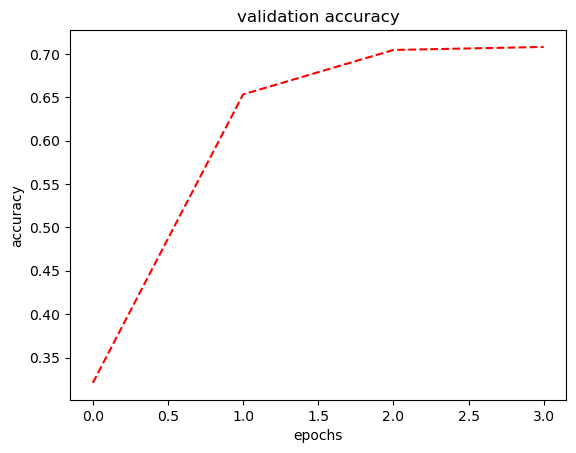

In [26]:
import matplotlib.pyplot as plt

def plot_broken_line(data,y,t):
    x = range(len(data))  # Generate x-axis values as indices of the list
    plt.plot(x, data, 'r--')  # Plot the data as a broken line with red dashed line style
    plt.xlabel('epochs')
    plt.ylabel(y)
    plt.title(t)
    plt.show()

plot_broken_line(train_loss2,"cross entropy loss","training loss")
plot_broken_line(val_loss2,"cross entropy loss","validation loss")
plot_broken_line(train_accuracy2,"accuracy","training accuracy")
plot_broken_line(val_accuracy2,"accuracy","validation accuracy")

In [28]:
labels2,pred2,loss32,totalacc32=run_model2(mymodel2,test_dataloader2,optimizer2,False)
print("epoch passed ------------------------------------------------------------------------------------------------")
print("total loss",loss32)
print("accuracy",totalacc32/len(y_test))

/tmp/ipykernel_28/3218481495.py:70: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  channel1=torch.tensor (image_features).float().clone().detach()
/tmp/ipykernel_28/3218481495.py:71: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  channel2=torch.tensor (text_in_features).float().clone().detach()


accuracy:  0.69140625
----------------------------------------------------------------
losssss tensor(0.3442, device='cuda:0', grad_fn=<MeanBackward0>)
----------------------------------------------------------------
epoch passed ------------------------------------------------------------------------------------------------
total loss 0.34419387578964233
accuracy 0.708


/tmp/ipykernel_28/99253527.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x).clone().detach().to(device)
/tmp/ipykernel_28/1490953845.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  loss_ = loss(torch.squeeze(output1.float()), torch.squeeze(torch.tensor(label1).to(device).float()))


In [29]:
print(train_accuracy2)
print(val_accuracy2)

[0.3404511278195489, 0.4899248120300752, 0.6285714285714286, 0.6803007518796993]
[0.32070175438596493, 0.6533333333333333, 0.7045614035087719, 0.7080701754385965]


In [ ]:
import pickle
filename = 'finalized_model1.sav'
pickle. dump(mymodel1, open (filename,'wb' ))
filename = 'finalized_model2.sav'
pickle. dump(mymodel2, open (filename,'wb' ))